# Safely applying safeguards to chunked datasets with `xarray-safeguards`

The `numcodecs-safeguards` frontend (and most methods in the `compression-safeguards`) assume that they are applied to the entire data at once, which allows them to preserve properties across neighbourhoods of points. If the safeguards are applied independently to different chunks of a chunked dataset, they are unable to provide their safety guarantees across the chunk boundaries. This example demonstrates this problem and showcases the `xarray-safeguards` frontend that enables safely applying safeguards to chunked datasets.

QPET does not support boundary conditions and could thus produce safety violations across chunk boundaries.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import copy
from pathlib import Path

import earthkit.plots
import humanize
import numpy as np
import xarray as xr
from numcodecs.abc import Codec

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
ERA5_U_chunked = ERA5_U.chunk(72)
print(ERA5_U_chunked.sizes)
ERA5_U_chunked.data

Frozen({'pressure_level': 1, 'latitude': 721, 'longitude': 1440})


dask.array<xarray-<this-array>, shape=(1, 721, 1440), dtype=float32, chunksize=(1, 72, 72), chunktype=numpy.ndarray>

In [5]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [6]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

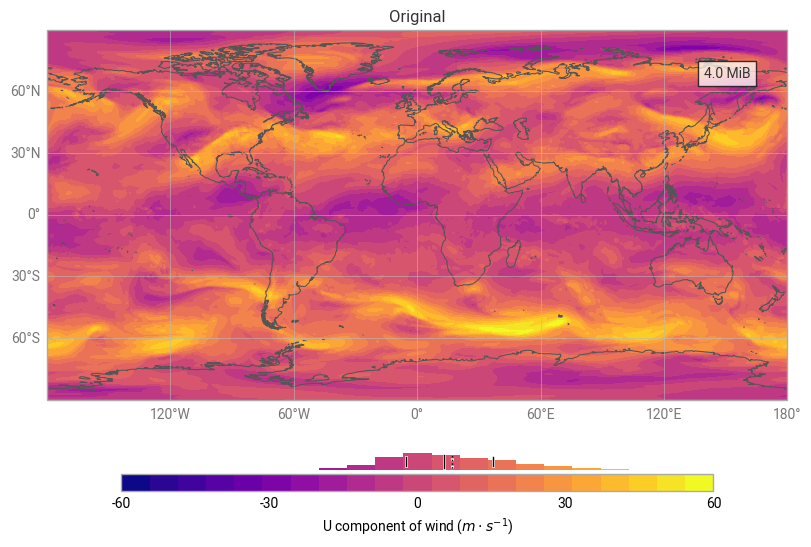

In [7]:
chart = earthkit.plots.Map()

# compute the default style that earthkit.maps would apply
source = earthkit.plots.sources.XarraySource(ERA5_U)
style = copy.deepcopy(
    earthkit.plots.styles.auto.guess_style(
        source,
        units=source.units,
    )
)
style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-60, 60, 22))
style._legend_kwargs["ticks"] = np.linspace(-60, 60, 5)

chart.quickplot(ERA5_U, style=style, zorder=-11)
chart.ax.set_rasterization_zorder(-10)

chart.title("Original")

t = chart.ax.text(
    0.95,
    0.9,
    humanize.naturalsize(ERA5_U.nbytes, binary=True),
    ha="right",
    va="top",
    transform=chart.ax.transAxes,
)
t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
    if m != "title":
        getattr(chart, m)()

for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
    getattr(chart, m)()

counts, bins = np.histogram(ERA5_U.values.flatten(), range=(-60, 60), bins=21)
midpoints = bins[:-1] + np.diff(bins) / 2
cb = chart.ax.collections[0].colorbar
cax = cb.ax.inset_axes([0.0, 1.25, 1.0, 1.0])
cax.bar(
    midpoints,
    height=counts,
    width=(bins[-1] - bins[0]) / len(counts),
    color=cb.cmap(cb.norm(midpoints)),
)
q1, q2, q3 = ERA5_U.quantile([0.25, 0.5, 0.75]).values
cax.axvline(ERA5_U.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
cax.axvline(ERA5_U.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
cax.set_xlim(-60, 60)
cax.set_xticks([])
cax.set_yticks([])
cax.spines[:].set_visible(False)

chart.save("chunked-original.pdf")

## 1. Applying the safeguards to the entire un-chunked dataset works as expected

To provide a visual example, we use a slightly contrived safeguard configuration that guarantees an absolute error bound of 1 m/s but, just for this demonstration, requires a two-grid-cell boundary on the latitude and longitude axes. By setting the boundary condition to `"valid"`, the safeguard is only applied to elements that have two cells to the left, right, top, and bottom. When applied to the full dataset, this includes all data points except for a two-grid-cell boundary around the full data domain.

In [8]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

from compression_safeguards import Safeguards

In [9]:
sg = Safeguards(
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="x",
            neighbourhood=[
                dict(axis=1, before=2, after=2, boundary="valid"),
                dict(axis=2, before=2, after=2, boundary="valid"),
            ],
            type="abs",
            eb=1.0,
        )
    ]
)

codec = ZeroCodec()

codec_sg = SafeguardsCodec(codec=codec, safeguards=sg.safeguards)

In [10]:
# Safely apply the safeguard to the entire data all at once
#  (by extracting the full unchunked data as a numpy array with `.values`)
ERA5_U_sg = ERA5_U_chunked.copy(
    data=codec_sg.decode(codec_sg.encode(ERA5_U_chunked.values))
).compute()

In [11]:
# When checking for safety violations, we need to remove a 2 grid-cell boundary
#  since our stencil safeguard above uses the valid boundary condition and thus
#  does not apply to the outer data boundary
print(
    f"Safeguards have {np.sum((np.abs(ERA5_U_sg - ERA5_U) >= 1.0)[:, 2:-2, 2:-2]).item()} safety requirement violations"
)

Safeguards have 0 safety requirement violations


## 2. Applying the safeguards independently across chunks creates near-boundary safety violations

We now demonstrate what happens when the above stencil safeguard is unsafely applied independently to each data chunk. Since the safeguard is not applied to a two-grid-cell boundary, now around each individual chunk, the safety requirements are expected to be violated around those chunk boundaries. When visualising the compression error, we can indeed observe chunk-boundary-aligned errors.

In [12]:
def encode_decode_independent_chunk(
    data: np.ndarray,
    codec: Codec,
) -> np.ndarray:
    return codec.decode(codec.encode(data))  # type: ignore

In [13]:
"""
The following is UNSAFE since the the QoI stencil safeguard is applied
independently applied to each chunk, risking safety violations at the
chunk boundaries.
"""

ERA5_U_sg_unsafe_chunked = ERA5_U_chunked.copy(
    data=ERA5_U_chunked.data.map_blocks(
        encode_decode_independent_chunk,
        dtype=ERA5_U_chunked.dtype,
        chunks=None,
        enforce_ndim=True,
        meta=np.array((), dtype=ERA5_U_chunked.dtype),
        codec=codec_sg,
    )
).compute()

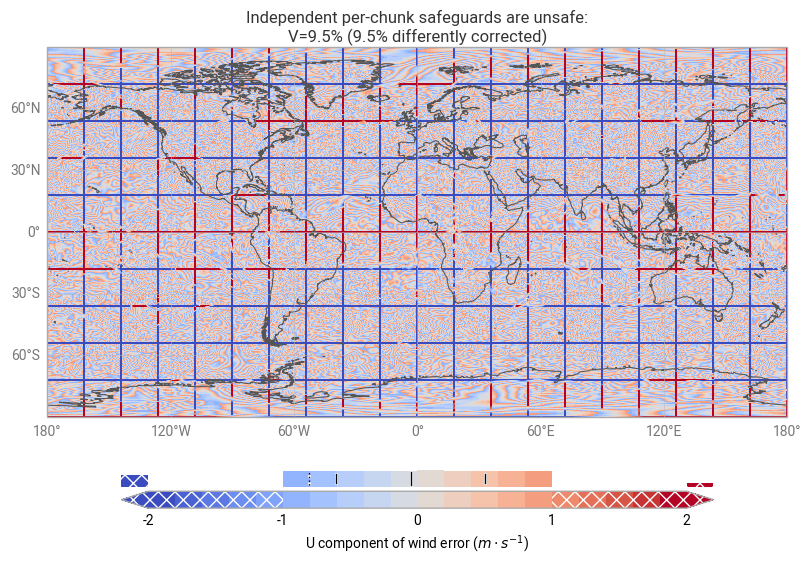

In [14]:
chart = earthkit.plots.Map()

with xr.set_options(keep_attrs=True):
    ERA5_U_sg_unsafe_chunked_error = ERA5_U_sg_unsafe_chunked - ERA5_U
ERA5_U_sg_unsafe_chunked_error.attrs.update(
    long_name=f"{ERA5_U_sg_unsafe_chunked_error.long_name} error"
)

# compute the default style that earthkit.maps would apply
source = earthkit.plots.sources.XarraySource(ERA5_U_sg_unsafe_chunked_error)
style = copy.deepcopy(
    earthkit.plots.styles.auto.guess_style(
        source,
        units=source.units,
    )
)
style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-2, 2, 21))
style._legend_kwargs["ticks"] = np.linspace(-2, 2, 5)
style._colors = "coolwarm"

extend_left = np.nanmin(ERA5_U_sg_unsafe_chunked_error) < -2
extend_right = np.nanmax(ERA5_U_sg_unsafe_chunked_error) > 2

extend = {
    (False, False): "neither",
    (True, False): "min",
    (False, True): "max",
    (True, True): "both",
}[(extend_left, extend_right)]

style._legend_kwargs["extend"] = extend
chart.pcolormesh(ERA5_U_sg_unsafe_chunked_error, style=style, zorder=-11)
chart.ax.set_rasterization_zorder(-10)

err_v = np.mean((np.abs(ERA5_U_sg_unsafe_chunked - ERA5_U) >= 1.0)[:, 2:-2, 2:-2])
sg_diff = np.mean(ERA5_U_sg_unsafe_chunked != ERA5_U_sg)

chart.title(
    "Independent per-chunk safeguards are unsafe:\n"
    + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
    + f" ({0 if sg_diff == 0 else np.format_float_positional(100 * sg_diff, precision=1, min_digits=1) + '%'}"
    + " differently corrected)"
)

for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
    if m != "title":
        getattr(chart, m)()

for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
    getattr(chart, m)()

counts, bins = np.histogram(
    ERA5_U_sg_unsafe_chunked_error.values.flatten(), range=(-2, 2), bins=20
)
midpoints = bins[:-1] + np.diff(bins) / 2
cb = chart.ax.collections[0].colorbar
if extend_left:
    cb._extend_patches[0].set_hatch("xx")
    cb._extend_patches[0].set_ec("white")
cb.ax.fill_between([-2, -1], *cb.ax.get_ylim(), hatch="xx", ec="w", fc="none", lw=0)
cb.ax.fill_between([1, 2], *cb.ax.get_ylim(), hatch="xx", ec="w", fc="none", lw=0)
if extend_right:
    cb._extend_patches[-1].set_hatch("xx")
    cb._extend_patches[-1].set_ec("white")
extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
cax = cb.ax.inset_axes(
    [
        0.0 - extend_width * extend_left,
        1.25,
        1.0 + extend_width * (0 + extend_left + extend_right),
        1.0,
    ]
)
cax.bar(
    midpoints,
    height=counts,
    width=(bins[-1] - bins[0]) / len(counts),
    color=cb.cmap(cb.norm(midpoints)),
    hatch=["xx" if np.abs(m) > 1.0 else "" for m in midpoints],
    ec="white",
    lw=0,
)
if extend_left:
    cax.bar(
        bins[0] - (bins[1] - bins[0]) / 2,
        height=np.sum(ERA5_U_sg_unsafe_chunked_error < -2),
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints[0])),
        hatch="xx",
        ec="white",
        lw=0,
    )
if extend_right:
    cax.bar(
        bins[-1] + (bins[-1] - bins[-2]) / 2,
        height=np.sum(ERA5_U_sg_unsafe_chunked_error > 2),
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints[-1])),
        hatch="xx",
        ec="white",
        lw=0,
    )
q1, q2, q3 = ERA5_U_sg_unsafe_chunked_error.quantile([0.25, 0.5, 0.75]).values
cax.axvline(
    ERA5_U_sg_unsafe_chunked_error.mean().values.item(),
    ls=":",
    ymin=0.1,
    ymax=0.9,
    c="w",
    lw=2,
)
cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
cax.axvline(
    ERA5_U_sg_unsafe_chunked_error.mean().values.item(),
    ymin=0.1,
    ymax=0.9,
    ls=":",
    c="k",
    lw=1,
)
cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
cax.set_xlim(
    -2 - (bins[-1] - bins[-2]) * extend_left, 2 + (bins[-1] - bins[-2]) * extend_right
)
cax.set_xticks([])
cax.set_yticks([])
cax.spines[:].set_visible(False)

chart.save("chunked-unsafe.pdf")

## 3. Safely applying safeguards across stencil-extended chunks using `xarray-safeguards`

Safely applying safeguards across chunks requires ensuring that the safeguards can also "see" the stencil around each chunk when computing the required corrections. Handling this process manually is very difficult and error-prone. The `xarray-safeguards` frontend provides a simple API to apply safeguards over datasets chunked with `dask` as well as convenient accessors to access safeguarded data.

Unlike the `numcodecs-safeguards` frontend, which uses its own data format to encode both the compressed data and corrections in a single bytestream, the `xarray-safeguards` frontend leaves compression to the user and simply produces a correction variable. This added flexibility then allows the correction to be losslessly compressed and stored in various ways, including as a separate file. Crucially, this outline storage allows the safeguards to be gradually adopted for *already compressed* data: as long as the original data and the lossy-compressed data exist, the safeguards correction can be late computed at any point to regain the required user safety requirements.

In [15]:
from xarray_safeguards import produce_data_array_correction

In [16]:
output = Path() / "data" / "output"

In [17]:
# first we independently create the lossy-compressed array ...
ERA5_U_zero = ERA5_U_chunked.copy(
    data=ERA5_U_chunked.data.map_blocks(
        encode_decode_independent_chunk,
        dtype=ERA5_U_chunked.dtype,
        chunks=None,
        enforce_ndim=True,
        meta=np.array((), dtype=ERA5_U_chunked.dtype),
        codec=codec,
    )
)

# ... and save it to disk
ERA5_U_zero.to_dataset().to_netcdf(output / "chunked-zero.nc")

In [18]:
# then we produce the safeguards correction ...
ERA5_U_sg_correction = produce_data_array_correction(
    # the original uncompressed data
    data=ERA5_U_chunked,
    # the lossy-decompressed data
    prediction=ERA5_U_zero,
    # the safeguards to apply
    safeguards=sg.safeguards,
)

# ... and save it to disk in a separate file
ERA5_U_sg_correction.to_dataset().to_netcdf(output / "chunked-zero-sg-correction.nc")

In [19]:
# now we combine both variables when loading the dataset from both files
# and apply the safeguards using the `.safeguarded` accessor on the dataset
# we can now even use completely different chunks
ERA5_sg_safe_chunked = xr.open_mfdataset(
    str(output / "chunked-zero*.nc"), chunks=36
).safeguarded
list(ERA5_sg_safe_chunked.variables)

['valid_time', 'longitude', 'latitude', 'pressure_level', 'u']

In [20]:
# we can also inspect the applied safeguards with the `.safeguards` property on the variable
ERA5_U_sg_safe_chunked = ERA5_sg_safe_chunked["u"]
print(ERA5_U_sg_safe_chunked.sizes)
display(ERA5_U_sg_safe_chunked.data)
print(ERA5_U_sg_safe_chunked.safeguards)

Frozen({'pressure_level': 1, 'latitude': 721, 'longitude': 1440})


dask.array<<this-array>-_apply_independent_chunk_correction, shape=(1, 721, 1440), dtype=float32, chunksize=(1, 36, 36), chunktype=numpy.ndarray>

(StencilQuantityOfInterestErrorBoundSafeguard(qoi='x', neighbourhood=[{'axis': 1, 'before': 2, 'after': 2, 'boundary': 'valid'}, {'axis': 2, 'before': 2, 'after': 2, 'boundary': 'valid'}], type='abs', eb=1.0, qoi_dtype='lossless'),)


In [21]:
print(
    f"Safely chunked safeguards have {np.sum(ERA5_U_sg_safe_chunked != ERA5_U_sg).compute().item()} differently corrected values"
)

print(
    f"Safely chunked safeguards have {np.sum((np.abs(ERA5_U_sg_safe_chunked - ERA5_U) >= 1.0)[:, 2:-2, 2:-2]).compute().item()} safety requirement violations"
)

Safely chunked safeguards have 0 differently corrected values
Safely chunked safeguards have 0 safety requirement violations
